# Performative Prediction: A Case Study in Strategic Classification

This notebook replicates the main experiments in [Performative Prediction](https://arxiv.org/abs/2002.06673):

- Juan C. Perdomo, Tijana Zrnic, Celestine Mendler-Dünner, Moritz Hardt. "Performative Prediction." arXiv preprint 2002.06673, 2020.

Strategic classification is a two-player game between an institution which deploys a classifier and agents who selectively adapt their features in order to improve their outcomes. This process is "performative" in the sense that the classifier deployed by the institution *causes* a change in the distribution of the target variable.

We use WhyNot to explore when repeatedly retraining the classifier on the new distributions *converges* to a stable point. For more details and theoretical calculations, see the original paper.

In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np

import whynot as wn
import whynot.gym as gym

import scripts.utils as utils

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Setting up the strategic classification environment

We use the [credit simulator](https://whynot.readthedocs.io/en/latest/simulators.html#credit-simulator), which is a strategic classification simulator based on the Kaggle [*Give Me Some Credit* dataset](https://www.kaggle.com/c/GiveMeSomeCredit).

In [2]:
env = gym.make('Credit-v0')
env.seed(1)

[1]

## Training a baseline logistic regression classifier

The state of the environment is a dataset consisting of (1) financial features of individuals, e.g. `DebtRatio`, and (2) a binary label indicating whether an individual experienced financial distress in the subsequent two years. 

In [3]:
base_dataset = env.initial_state.values()
base_features, base_labels = base_dataset["features"], base_dataset["labels"]
num_agents, num_features = base_features.shape
print(f"The dataset has {num_agents} agents and {num_features} features.")

The dataset has 18357 agents and 11 features.


Fit a logistic regression model to the data

In [4]:
l2_penalty = 1.0 / num_agents
baseline_theta = utils.fit_logistic_regression(base_features, base_labels, l2_penalty)
baseline_acc = ((base_features.dot(baseline_theta) > 0)  == base_labels).mean()
print(f"Baseline logistic regresion model accuracy: {100 * baseline_acc:.2f}%")

Baseline logistic regresion model accuracy: 72.08%


## Running repeated risk minimization

Using the credit environment, we simulate repeated retraining of the logistic regression model in response to
strategic distribution shift. We perform `num_iters` rounds. In each round:
1. We train an logistic regression classifier on the current set of features
2. The classifier is deployed via `env.step(theta)`
3. In the environment, individuals react strategically to the deployed classifier, and the environment returns a new set of fetaures for the next round.

The parameter `epsilon` changes the strength of the strategic response. Higher values of epsilon correspond to proportionally more strategic distribution shift. Each run is warm-started with the `baseline_theta` classifier computed without strategic response.

In [7]:
def repeated_risk_minimization(base_theta, epsilon, num_steps):
    """Run repeated risk minimization for num_iters steps"""
    env.config.epsilon = epsilon
    env.config.l2_penalty = l2_penalty
    env.reset()
    
    # Track loss and accuracy before/after updating model on new distribution
    loss_start, loss_end, acc_start, acc_end, theta_gap = [], [], [], [], []
    
    # Warm-start with baseline classifier
    theta = np.copy(base_theta)
    for step in range(num_steps):
        
        # Deploy classifier and observe strategic response
        observation, _, _, _ = env.step(theta)
        features_strat, labels = observation["features"], observation["labels"]
        
        # Evaluate loss and accuracy on the new distribution
        loss_start.append(
            utils.evaluate_logistic_loss(features_strat, labels, theta, l2_penalty))
        acc_start.append(
            ((features_strat.dot(theta) > 0) == labels).mean()
        )
        
        # Learn a new model on the induced distribution
        theta_new = utils.fit_logistic_regression(features_strat, labels, l2_penalty,
                                                  theta_init=np.copy(theta))
        
        
        # Evaluate loss and accuracy on the strategic distribution after training
        loss_end.append(
            utils.evaluate_logistic_loss(features_strat, labels, theta_new, l2_penalty)
        )
        acc_end.append(
            ((features_strat.dot(theta_new) > 0) == labels).mean()
        )
        
        # Track distance between iterates
        theta_gap.append(np.linalg.norm(theta_new - theta))
        
        theta = np.copy(theta_new)
        
    return loss_start, loss_end, acc_start, acc_end, theta_gap

In [31]:
epsilon_list = [1, 80, 150, 1000]
num_iters = 25

loss_starts, acc_starts, loss_ends, acc_ends, theta_gaps = [], [], [], [], []
for epsilon_idx, epsilon in enumerate(epsilon_list):
    print(f"Running retraining for epsilon {epsilon:.2f}")

    loss_start, loss_end, acc_start, acc_end, theta_gap = repeated_risk_minimization(
        baseline_theta, epsilon, num_iters)
    loss_starts.append(loss_start)
    loss_ends.append(loss_end)
    acc_starts.append(acc_start)
    acc_ends.append(acc_end)
    theta_gaps.append(theta_gap)

Running retraining for epsilon 1.00
Running retraining for epsilon 80.00
Running retraining for epsilon 150.00
Running retraining for epsilon 1000.00


## Visualizing the results

We visualize the perfromative risk during the repeated risk minimization procedure. We plot the risk at the beginning and at the end of each round, connecting the two values with a blue line and indicating change in risk due to strategic distribution shift with a dashed green line.

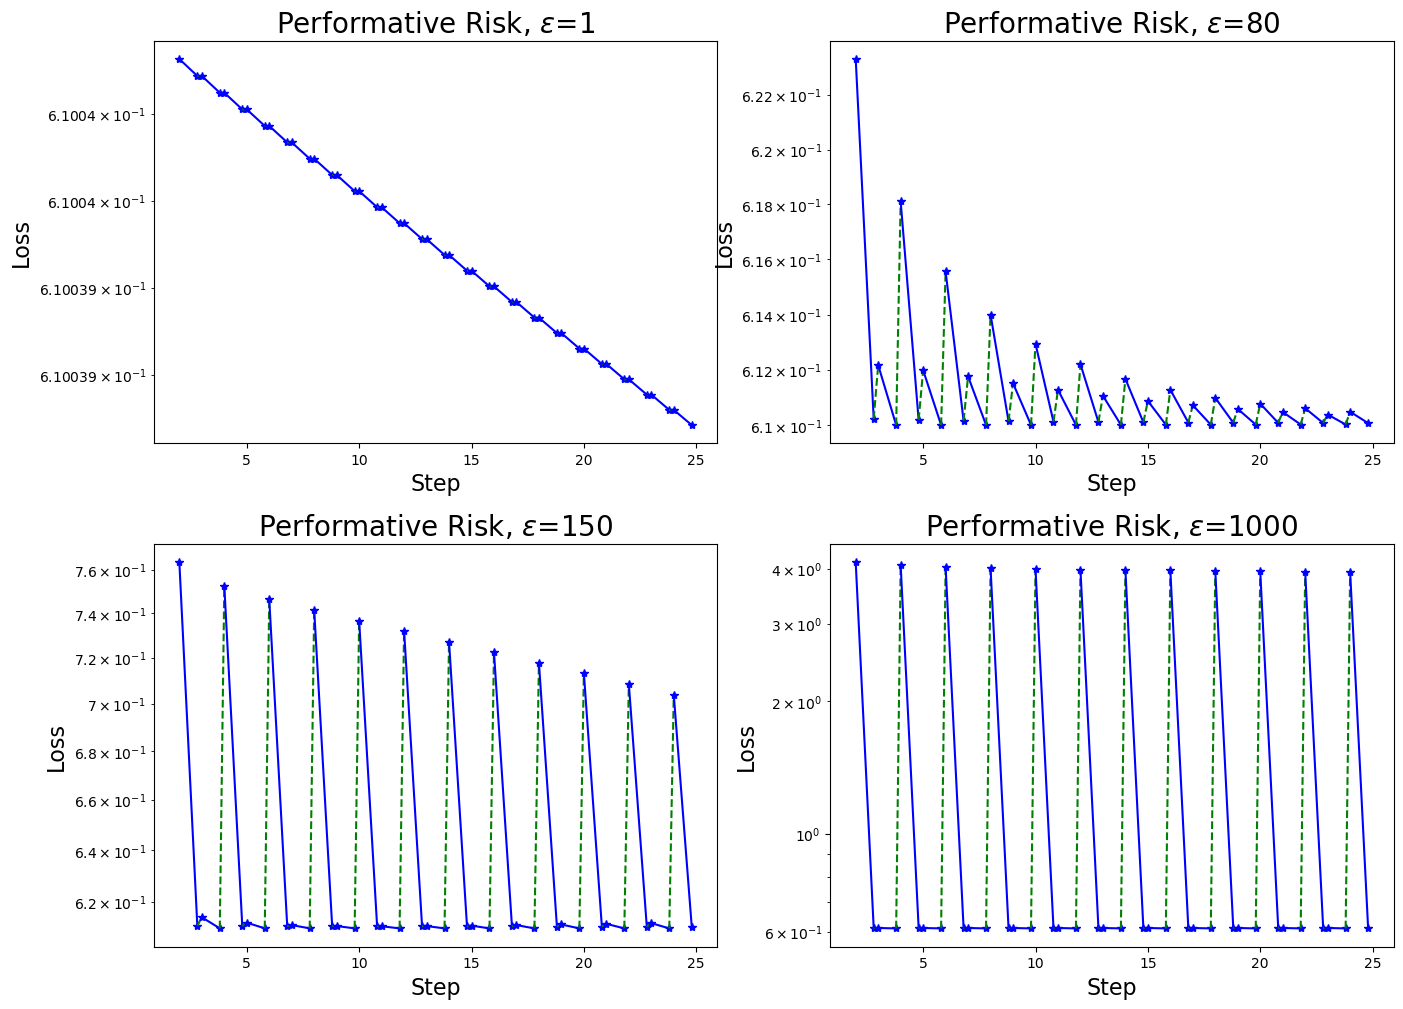

In [32]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16, 12))
for idx, epsilon in enumerate(epsilon_list):
    ax = axes[idx // 2][idx % 2]
    offset = 0.8
    ax.set_title(f"Performative Risk, $\epsilon$={epsilon}", fontsize=20)
    for i in range(2, num_iters):
        ax.plot([i,i + offset],[loss_starts[idx][i], loss_ends[idx][i]],'b*-')
        if i < num_iters - 1:
            ax.plot([i + offset, i + 1],[loss_ends[idx][i], loss_starts[idx][i + 1]],'g--')

    ax.set_xlabel("Step", fontsize=16)
    ax.set_ylabel("Loss", fontsize=16)
    ax.set_yscale('log')
plt.subplots_adjust(hspace=0.25)

The performative risk is a surrogate for the underlying metric we care about, accuracy. We can similarly plot accuracy during retraining.

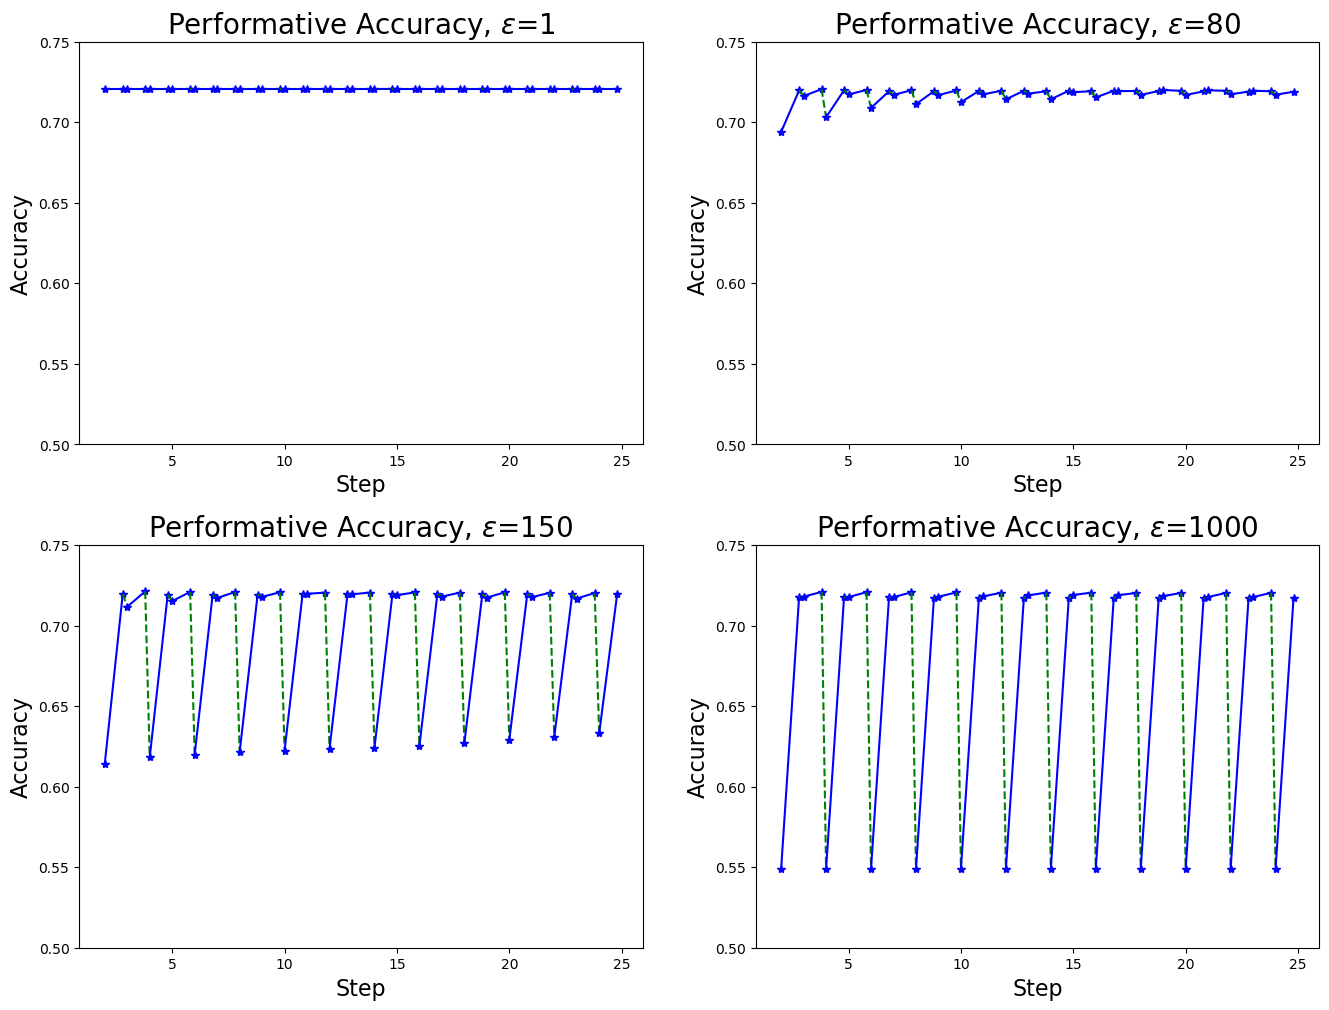

In [33]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16, 12))
for idx, epsilon in enumerate(epsilon_list):
    ax = axes[idx // 2][idx % 2]
    offset = 0.8
    ax.set_title(f"Performative Accuracy, $\epsilon$={epsilon}", fontsize=20)
    for i in range(2, num_iters):
        ax.plot([i,i + offset],[acc_starts[idx][i], acc_ends[idx][i]],'b*-')
        if i < num_iters - 1:
            ax.plot([i + offset, i + 1],[acc_ends[idx][i], acc_starts[idx][i + 1]],'g--')

    ax.set_xlabel("Step", fontsize=16)
    ax.set_ylabel("Accuracy", fontsize=16)
    ax.set_ylim([0.5, 0.75])
plt.subplots_adjust(hspace=0.25)

Finally, we plot the distance between consecutive iterates. This is the quantity bounded by the theorems in Performative Prediction, which shows that repeated risk minimization *converges in domain* to a stable point.

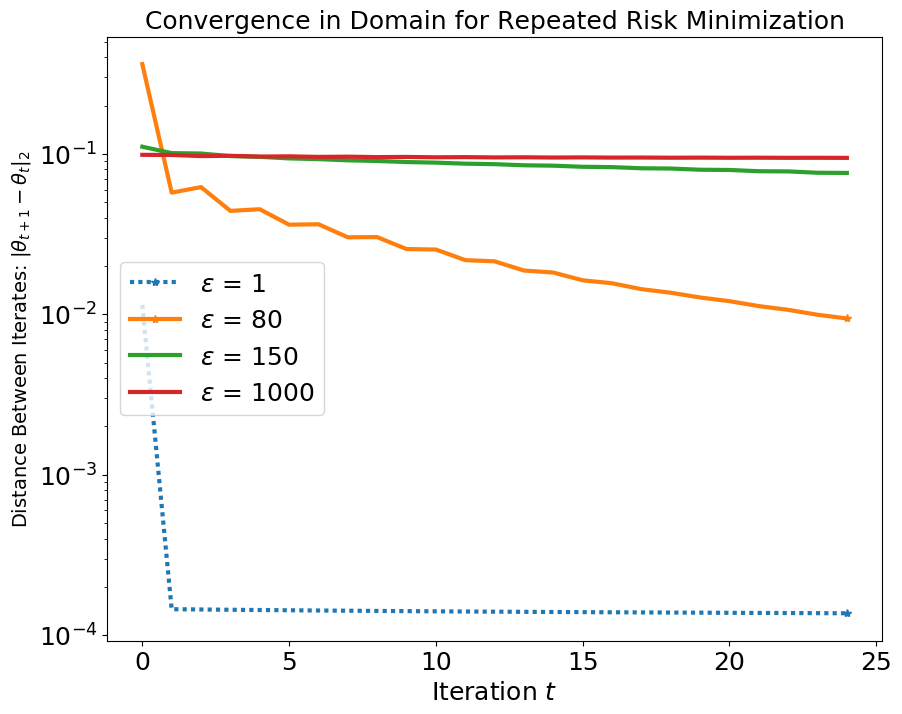

In [48]:
processed_theta_gaps = [[x for x in tg if x != 0.0] for tg in theta_gaps]
_, ax = plt.subplots(figsize=(10, 8))

for idx, (gaps, eps) in enumerate(zip(processed_theta_gaps, epsilon_list)):
    label = '$\\varepsilon$ = {}'.format(eps)
    if idx == 0:
        ax.semilogy(gaps, label=label, linewidth=3,  alpha=1,
                 markevery=[-1], marker='*', linestyle=(0, (1, 1)))
    elif idx == 1:
        ax.semilogy(gaps, label=label, linewidth=3,  alpha=1,
                 markevery=[-1], marker='*', linestyle='solid')
    else:
        ax.semilogy(gaps, label=label, linewidth=3)


ax.set_title("Convergence in Domain for Repeated Risk Minimization", fontsize=18)
ax.set_xlabel('Iteration $t$',fontsize=18)
ax.set_ylabel(r'Distance Between Iterates: $\|\theta_{t+1} - \theta_{t}\|_2 $', fontsize=14)
ax.tick_params(labelsize=18)
plt.legend(fontsize=18)